<a href="https://colab.research.google.com/github/myconcordia/A2I2/blob/main/Darts_AirQuality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install Darts**
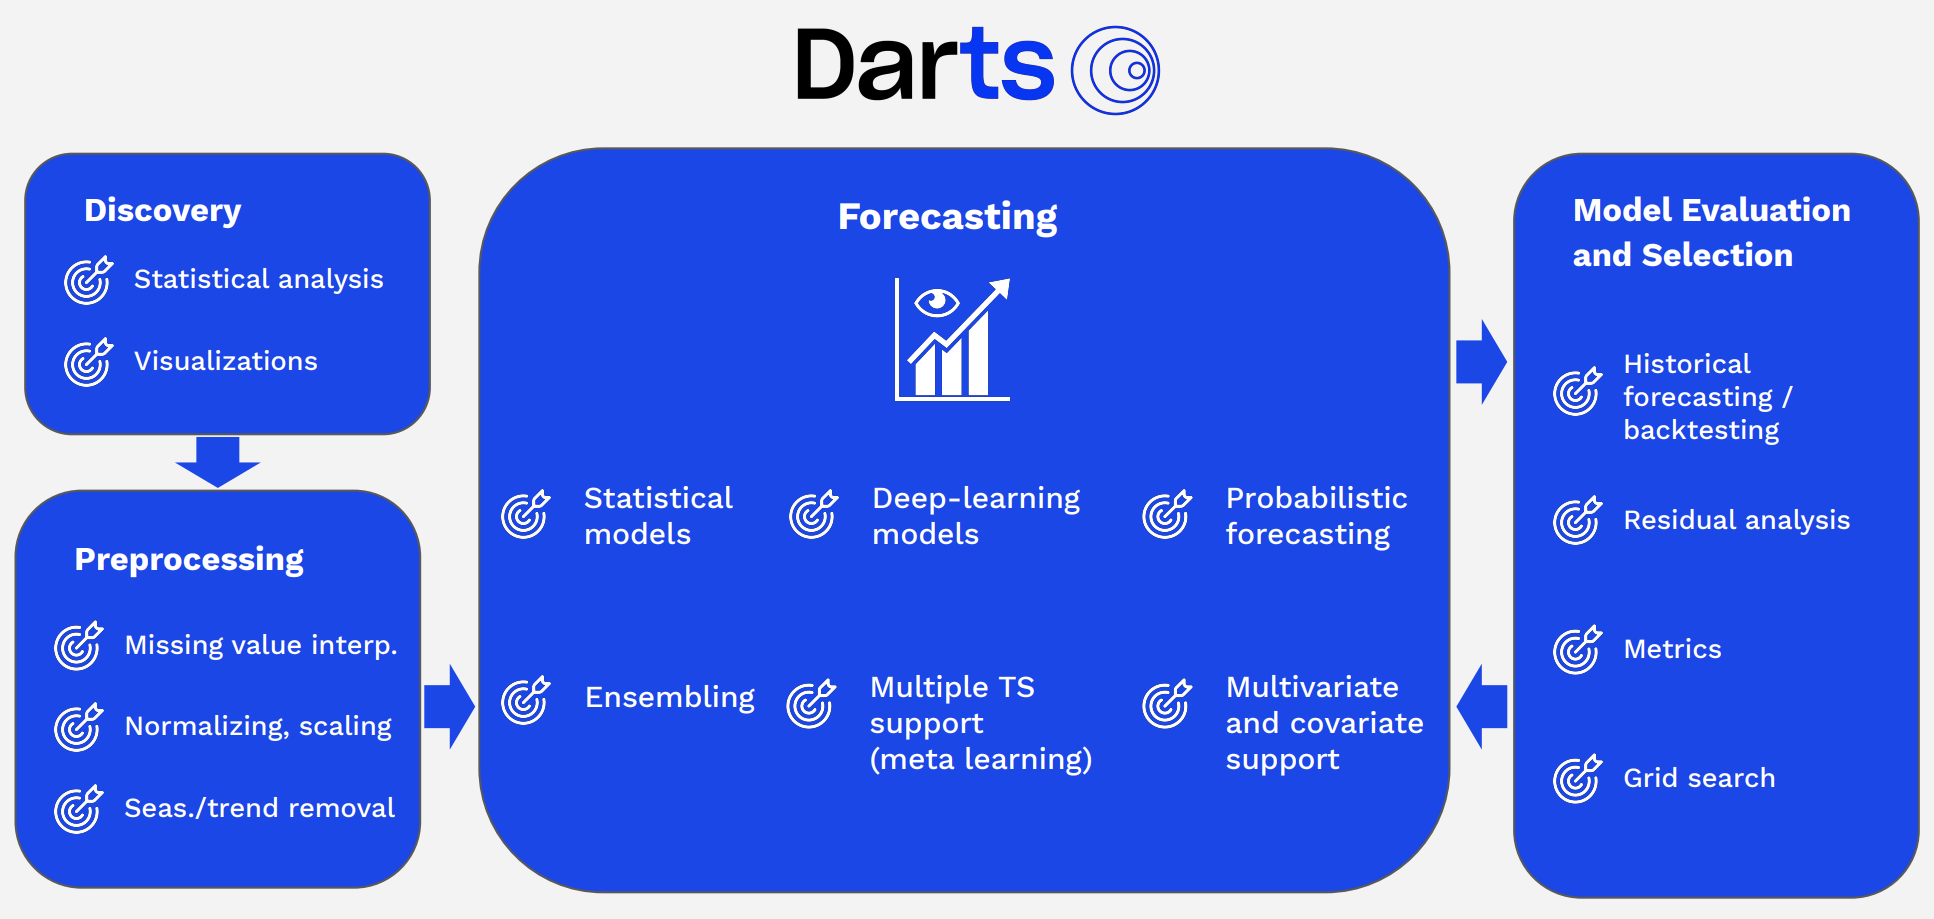

In [1]:
!pip install darts --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 846.9/846.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 

**Import Libraries**

In [2]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import pandas as pd
plt.rcParams['figure.figsize'] = (7,5)

import torch
from darts.metrics import mape, smape, mae, rmse
from darts import TimeSeries

from darts.utils.callbacks import TFMProgressBar

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

**Dataset**

In [3]:
#read csv file into dataframe
data_url = 'https://raw.githubusercontent.com/myconcordia/A2I2/main/Air_Quality.csv'
df = pd.read_csv(data_url)
df.info(memory_usage='deep')
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    153 non-null    object 
 1   Ozone   116 non-null    float64
 2   Solar   146 non-null    float64
 3   Wind    153 non-null    float64
 4   Temp    153 non-null    int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 14.9 KB


,Date,Ozone,Solar,Wind,Temp
0,1976-05-01,41.0,190.0,7.4,67
1,1976-05-02,36.0,118.0,8.0,72
2,1976-05-03,12.0,149.0,12.6,74
3,1976-05-04,18.0,313.0,11.5,62
4,1976-05-05,NaN,NaN,14.3,56
5,1976-05-06,28.0,NaN,14.9,66
6,1976-05-07,23.0,299.0,8.6,65
7,1976-05-08,19.0,99.0,13.8,59
8,1976-05-09,8.0,19.0,20.1,61
9,1976-05-10,NaN,194.0,8.6,69


**Optimize your Pandas data frame's memory footprint**

In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    153 non-null    datetime64[ns]
 1   Ozone   116 non-null    float64       
 2   Solar   146 non-null    float64       
 3   Wind    153 non-null    float64       
 4   Temp    153 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 6.1 KB


In [20]:
#df['Ozone'] = df['Ozone'].astype('int64')  #gives errors because of NaNs
df['Ozone'] = df['Ozone'].astype('float16')
#df['Solar'] = df['Solar'].astype('float16')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    153 non-null    datetime64[ns]
 1   Ozone   116 non-null    float16       
 2   Solar   146 non-null    float16       
 3   Wind    153 non-null    float64       
 4   Temp    153 non-null    int64         
dtypes: datetime64[ns](1), float16(2), float64(1), int64(1)
memory usage: 4.3 KB


**Analysis of Missing Data by Visualisation**

<Axes: >

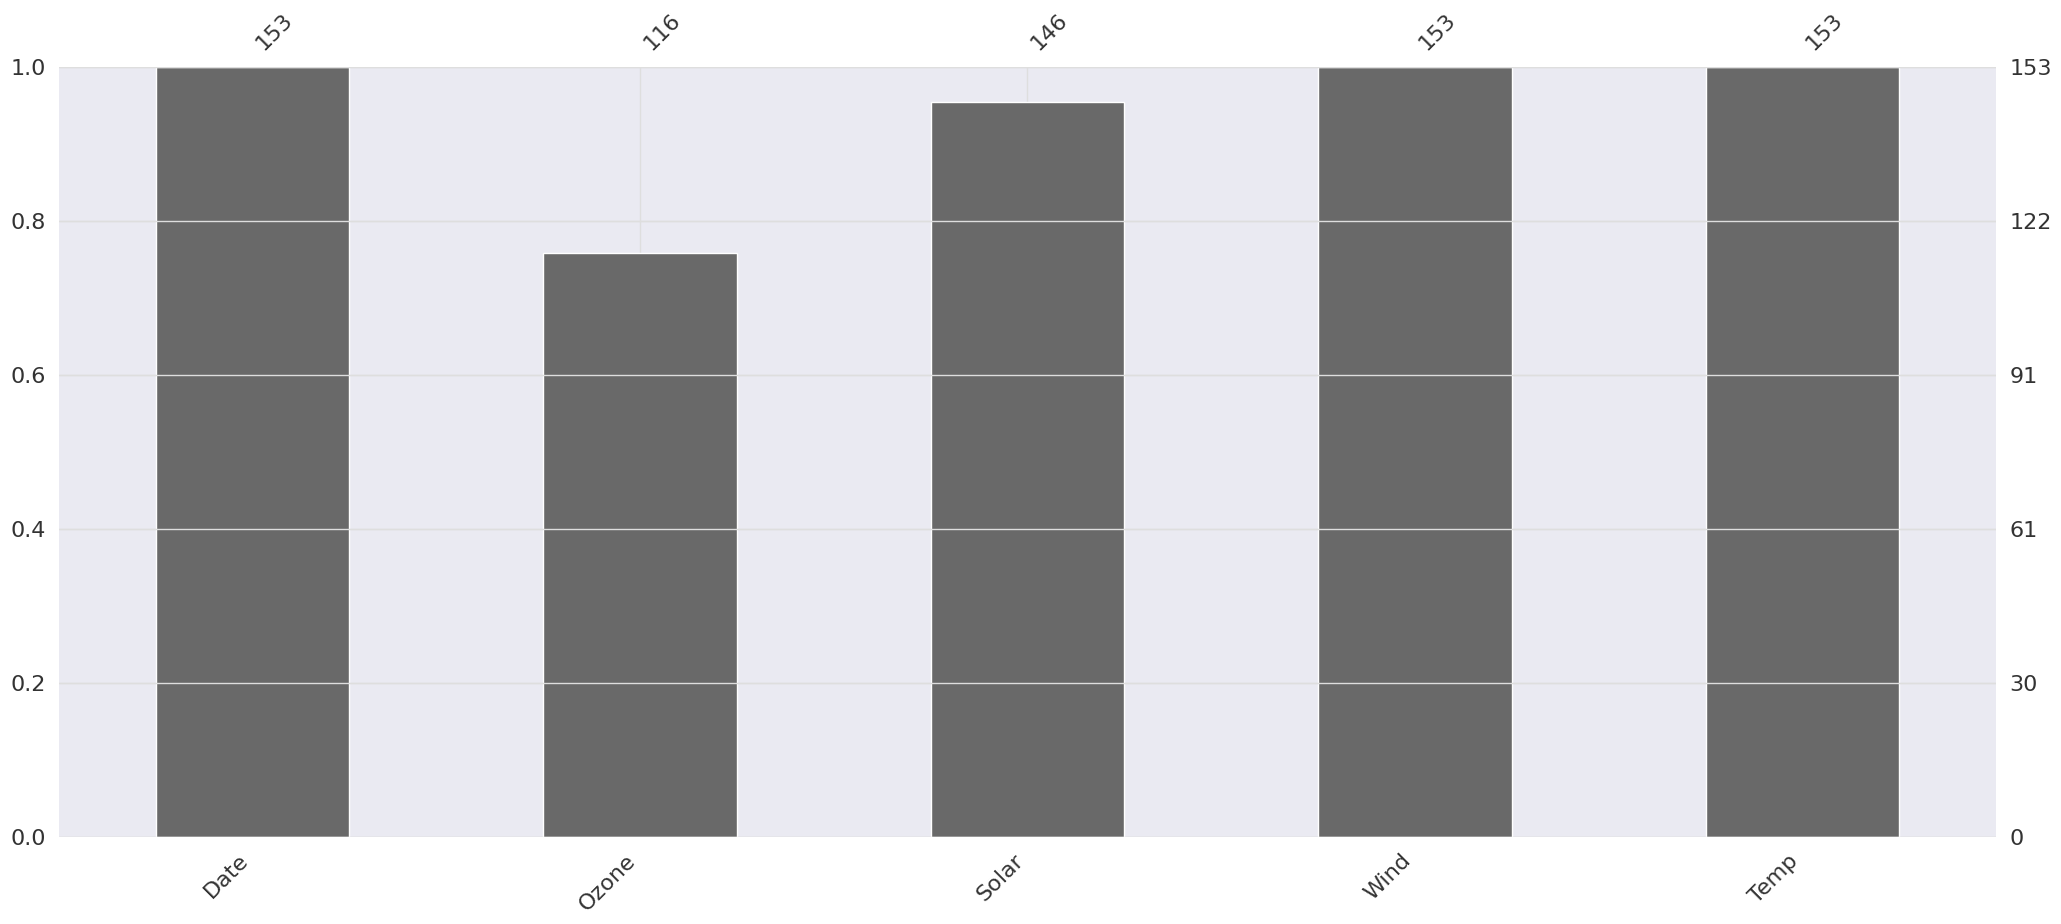

In [21]:
# Import missingno as msno
import missingno as msno
# Plot amount of missingness (visualization of nullity by column)
msno.bar(df)

<Axes: >

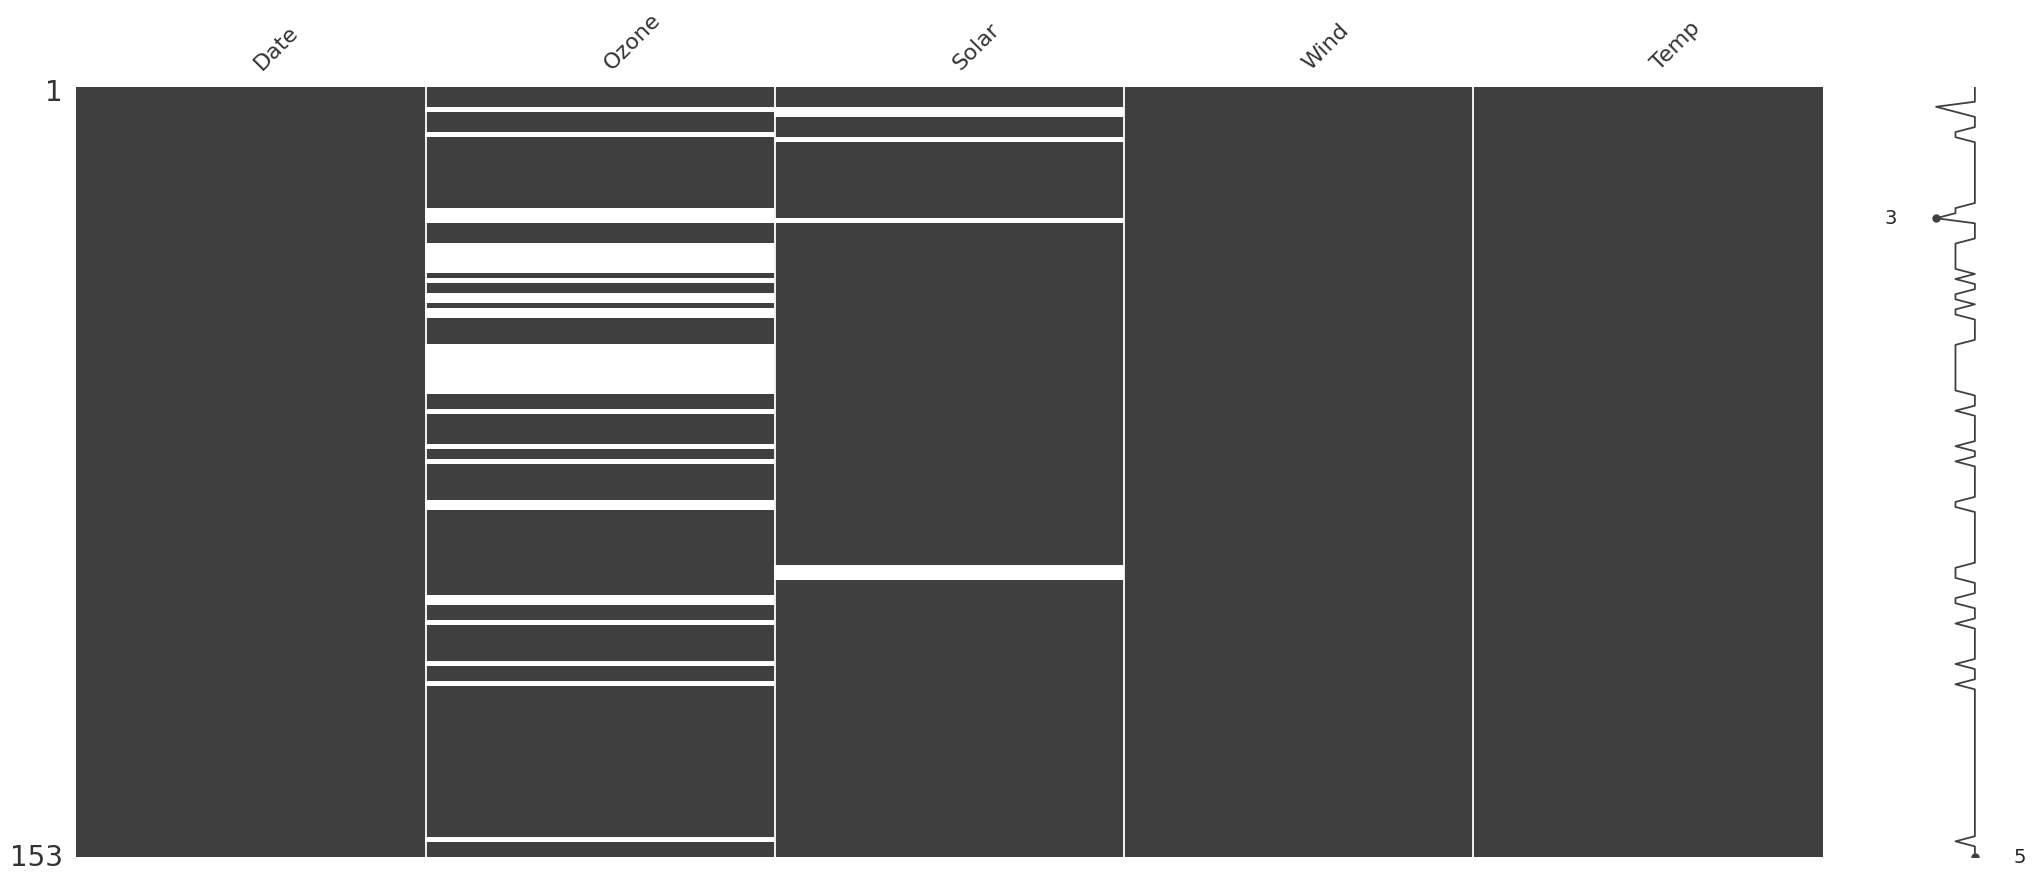

In [22]:
msno.matrix(df)

The sparkline on the right right summarizes the general shape of the data completeness and points out the rows with the maximum and minimum nullity in the dataset.

**How to select certain columns**

In [23]:
dfc = pd.read_csv(data_url, usecols=['Date', 'Ozone', 'Temp'])
dfc.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    153 non-null    object 
 1   Ozone   116 non-null    float64
 2   Temp    153 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5 KB


In [ ]:
#Add NaNs to Ozone every five reads
#dfc.loc[::5, 'Ozone'] = np.nan
#dfc.head(7)

**Interpolation (fill missing values)**

In [24]:
dfc.head(6)

,Date,Ozone,Temp
0,1976-05-01,41.0,67
1,1976-05-02,36.0,72
2,1976-05-03,12.0,74
3,1976-05-04,18.0,62
4,1976-05-05,NaN,56
5,1976-05-06,28.0,66


https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate


The **df.interpolate()** method in pandas offers several interpolation methods to fill missing values in a DataFrame or Series. Here's an explanation of the various methods available:

**linear** (default): This method performs linear interpolation, which fills missing values with a linearly interpolated value based on the surrounding non-missing values. It calculates the missing values by drawing a straight line between the two nearest non-missing values.

**time**: If the index of the DataFrame or Series is datetime-like, the time method performs interpolation based on time. It works similarly to linear interpolation but considers the time intervals between data points when interpolating missing values.

**index**: This method is similar to the time method but doesn't require the index to be datetime-like. It interpolates based on the index values of the DataFrame or Series.

**values**: The values method fills missing values by considering the numeric values in the DataFrame or Series without considering the index. It performs linear interpolation based solely on the position of the missing values within the dataset.

**polynomial**: This method performs polynomial interpolation to fill missing values. It fits a polynomial curve to the data points surrounding the missing values and uses that curve to estimate the missing values.

**spline**: The spline method performs spline interpolation, which fits a piecewise polynomial curve to the data points and smoothly interpolates missing values based on the curve.

https://note.nkmk.me/en/python-pandas-interpolate/

In [25]:
#Interpolate uses 'linear' method (i.e., replace NaN with average values) by default
#method = ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘barycentric’, ‘polynomial’
dfc.interpolate().head(6)

,Date,Ozone,Temp
0,1976-05-01,41.0,67
1,1976-05-02,36.0,72
2,1976-05-03,12.0,74
3,1976-05-04,18.0,62
4,1976-05-05,23.0,56
5,1976-05-06,28.0,66


<Axes: >

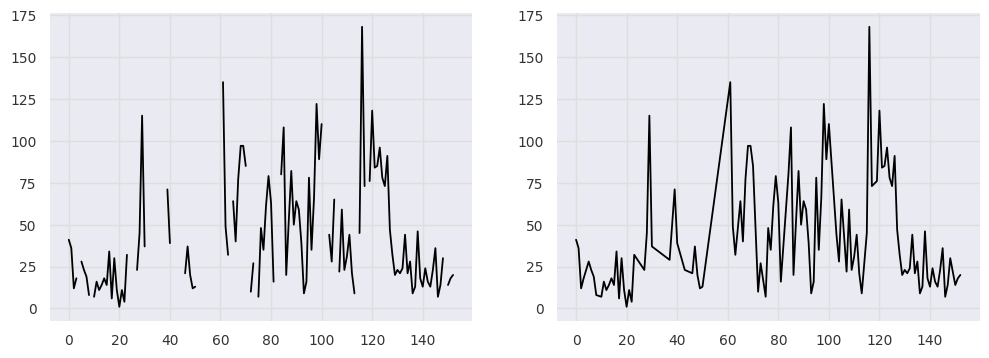

In [40]:
#Display two plots side by side (before and after interpolation)
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
dfc['Ozone'].plot(ax=ax0)
dfc['Ozone'].interpolate().plot(ax=ax1)

NaN values are computed as follows: step_size = (max-min)/(#NaNs+1). For instance, (37-29)/(6+1) = 1.142857, which the increment starting from the smallest value 29.

In [39]:
#Display two Pandas data frames side by side
df_joint = pd.concat([dfc, dfc.interpolate()], axis=1, join='inner')
df_joint.head(40)

,Date,Ozone,Temp,Date,Ozone,Temp
0,1976-05-01,41.0,67,1976-05-01,41.000000,67
1,1976-05-02,36.0,72,1976-05-02,36.000000,72
2,1976-05-03,12.0,74,1976-05-03,12.000000,74
3,1976-05-04,18.0,62,1976-05-04,18.000000,62
4,1976-05-05,NaN,56,1976-05-05,23.000000,56
5,1976-05-06,28.0,66,1976-05-06,28.000000,66
6,1976-05-07,23.0,65,1976-05-07,23.000000,65
7,1976-05-08,19.0,59,1976-05-08,19.000000,59
8,1976-05-09,8.0,61,1976-05-09,8.000000,61
9,1976-05-10,NaN,69,1976-05-10,7.500000,69


In [41]:
dfc.interpolate(method='spline', limit_direction='both', order=1).head(6)

,Date,Ozone,Temp
0,1976-05-01,41.000000,67
1,1976-05-02,36.000000,72
2,1976-05-03,12.000000,74
3,1976-05-04,18.000000,62
4,1976-05-05,22.858911,56
5,1976-05-06,28.000000,66


<Axes: >

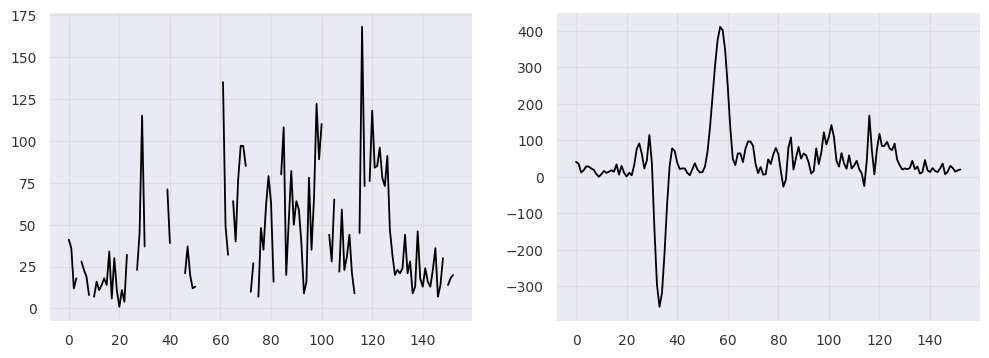

In [50]:
fig, (ax0,ax1) = plt.subplots(nrows=1,ncols=2, figsize=(12,4))
dfc['Ozone'].plot(ax=ax0)
dfc['Ozone'].interpolate(method='spline', order=2).plot(ax=ax1)

**Read and Plot Time Series Data**

'the dataset has 153 data points'

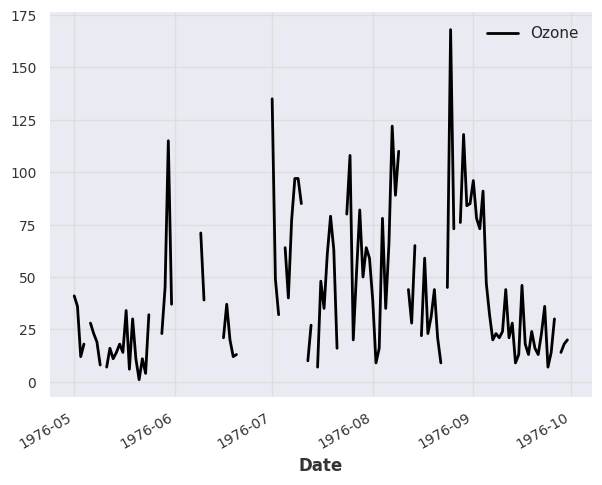

In [51]:
# create a Time Series object from the dataframe
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='Ozone')
series.plot()
"the dataset has {} data points".format(len(series))

<Axes: xlabel='Date'>

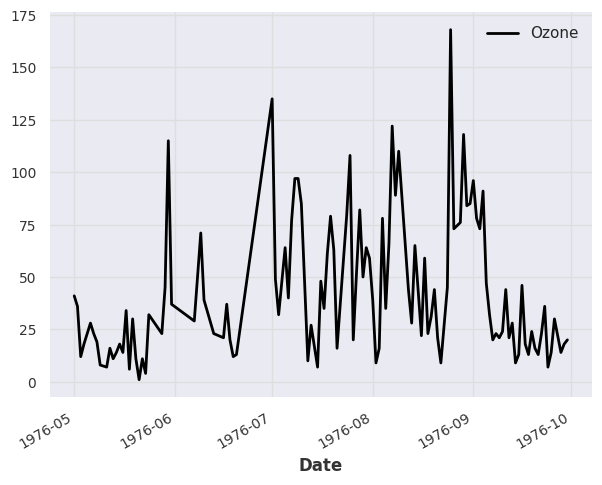

In [85]:
##pre-processing
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series, fill='auto')
series.plot()

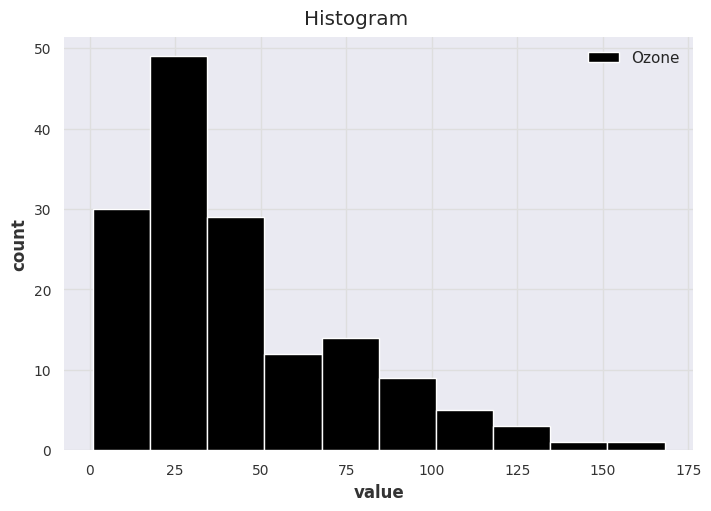

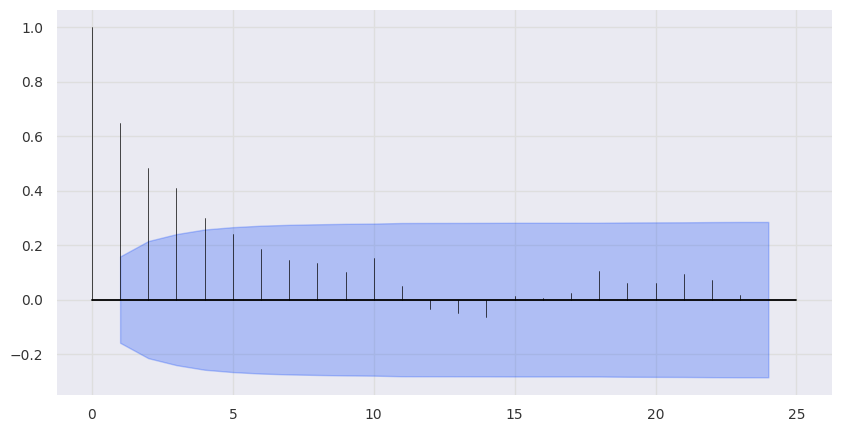

In [ ]:
from darts.utils.statistics import plot_hist, plot_acf
#Plots the histogram of values in a TimeSeries
plot_hist(series)
#Plots the Autocorrelation Function (ACF) of ts
plot_acf(series)

23


'the resampled dataset has 23 data points'

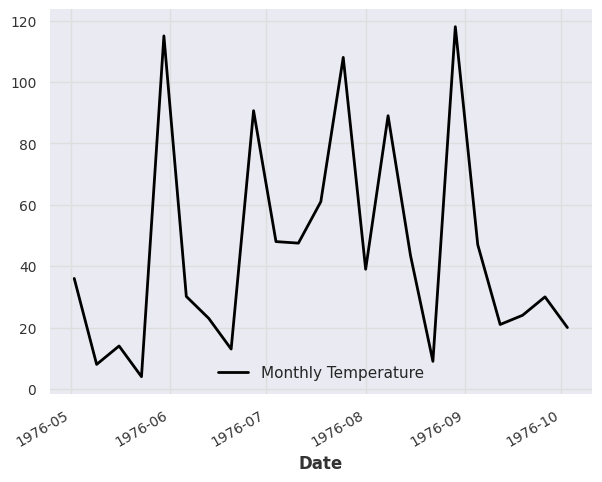

In [ ]:
#What if we want to plot our data on a weekly basis instead? We can just resample!
# Resampling and frequency conversion
resampled_series = series.resample("W")
resampled_series.plot(label="Monthly Temperature")
print(resampled_series.n_timesteps)
"the resampled dataset has {} data points".format(len(resampled_series))

**Preprocessing**

Usually neural networks tend to work better on normalised/standardised data. Here we’ll use the Scaler class to normalise both of our time series between 0 and 1:

"the 'daily temperature' dataset has 153 data points"

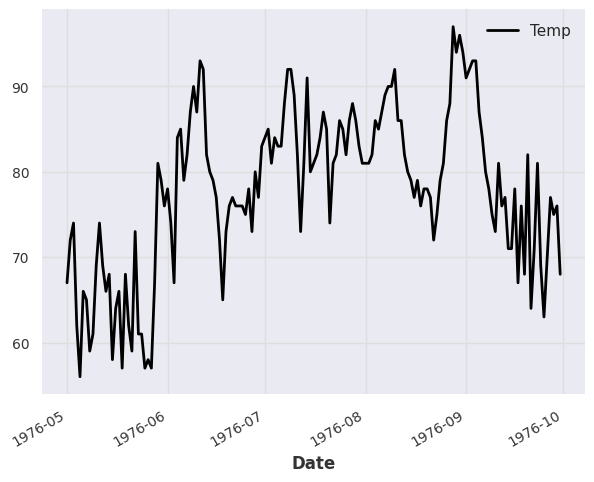

In [ ]:
# create a Time Series object from the dataframe
series = TimeSeries.from_dataframe(df, time_col='Date', value_cols='Temp')
series.plot()
"the 'daily temperature' dataset has {} data points".format(len(series))

<Axes: xlabel='Date'>

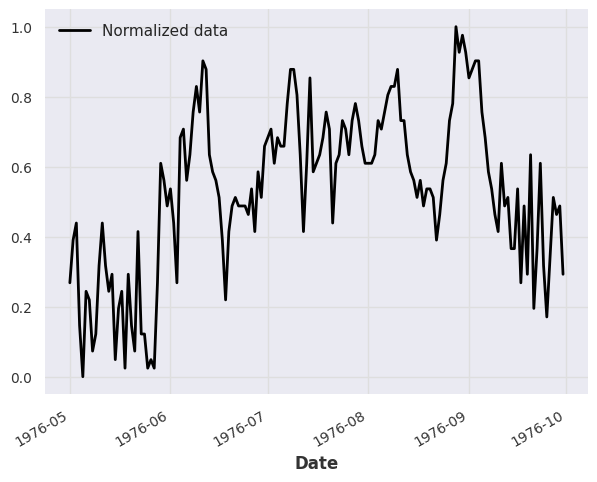

In [ ]:
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()
series = scaler.fit_transform(series)

series.plot(label="Normalized data")

https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

**Partition data into trainign and testing**

<Axes: xlabel='Date'>

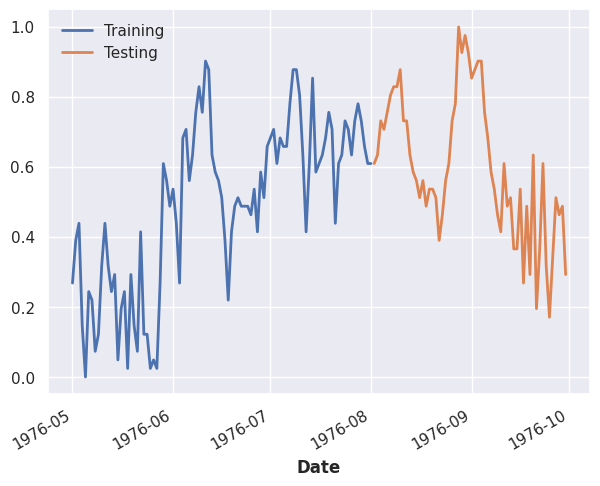

In [ ]:
# Set aside the last 60 days as a test series
train, test = series[:-60], series[-60:]
train.plot(label="Training")
test.plot(label="Testing")

**Another way to partition the data into training and testing**

In [ ]:
#test_size = 60/len(df)  #last 60 days
#train_size = 1-test_size
#train_size

<Axes: xlabel='Date'>

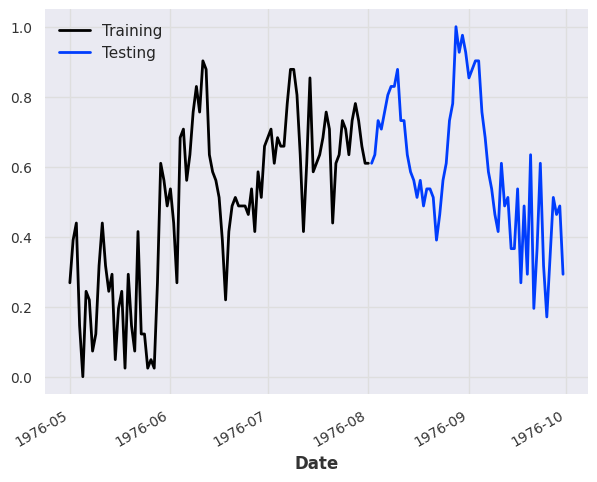

In [ ]:
from darts.utils.model_selection import train_test_split

train, test = train_test_split(series, test_size=60/len(df))
train.plot(label="Training")
test.plot(label="Testing")

In [ ]:
#create a training and test set
#train, test = series.split_before(pd.Timestamp(ts_input="19760801"))
#train, test = series.split_after(1-60/len(df))
#train.plot(label="Training")
#test.plot(label="Testing")

**Import Models**

In [ ]:
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    NaiveDrift,
    NaiveSeasonal,
    XGBModel,
    VARIMA,
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    NHiTSModel,
    TBATS,
    BlockRNNModel,
    Theta,
    DLinearModel,
    NLinearModel,
    TiDEModel,
)

<Axes: xlabel='Date'>

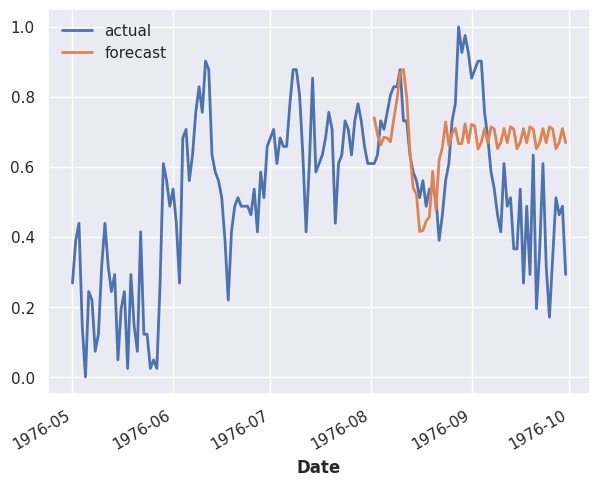

In [ ]:
model = XGBModel(lags=7, #  number of lagged target values used to predict the next time step
                 n_estimators=100, # number of trees in the model
                max_depth=6) # maximum depth of the tree - used to control overfitting, too deep and noise of the data will be learned

# fit the xgb model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

**Hyperparameter tuning (trying different lags values)**

<Axes: xlabel='Date'>

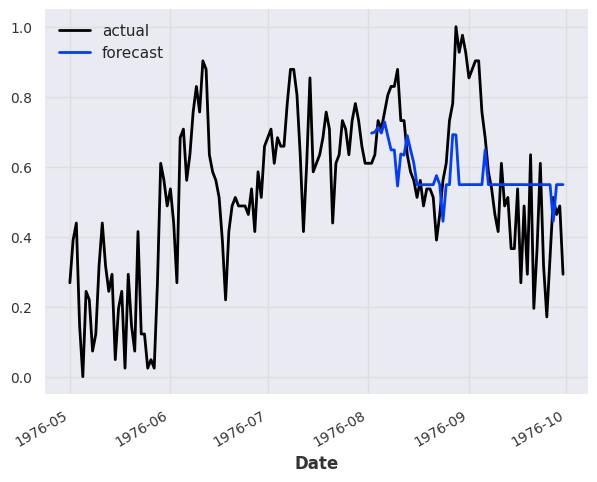

In [ ]:
from os import preadv
model = XGBModel(lags=80)

# fit the xgb model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

**D-Linear Model**

https://arxiv.org/pdf/2205.13504.pdf

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 210   
5 | linear_trend    | Linear           | 210   
-----------------------------------------------------
420       Trainable p

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


<Axes: xlabel='Date'>

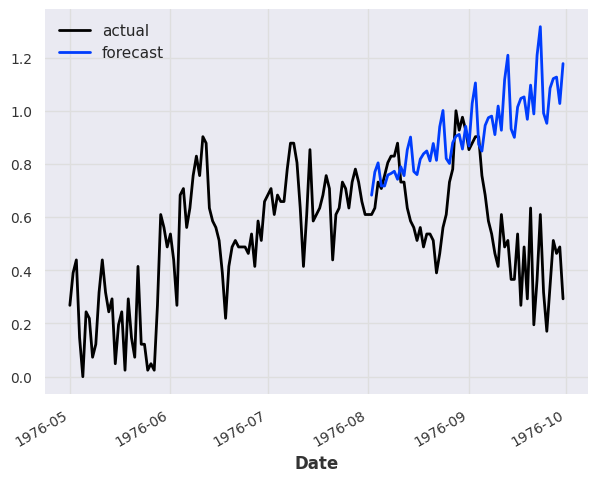

In [ ]:
model = DLinearModel(
    input_chunk_length=20,
    output_chunk_length=10,
    n_epochs=50,
    random_state=0,
    **generate_torch_kwargs()
)

# fit the model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

Let’s build an N-BEATS model that has a lookback window of 24 points (input_chunk_length=24) and predicts the next 12 points (output_chunk_length=12). We chose these values so it’ll make our model produce successive predictions for one year at a time, looking at the past two years.

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.2 M 
---------------------------------------------------
6.2 M     Trainable params
1.4 K     Non-trainable params
6.2 M     Total params
24.787    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


MAPE = 48.40%


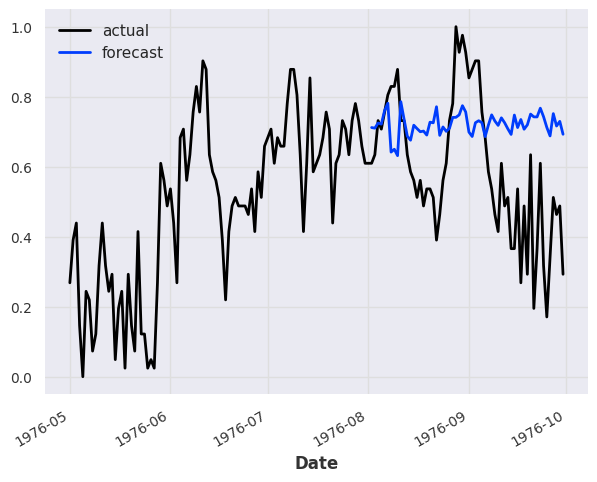

In [ ]:
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=50,
    random_state=0,
    **generate_torch_kwargs()
)

# fit the model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

series.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


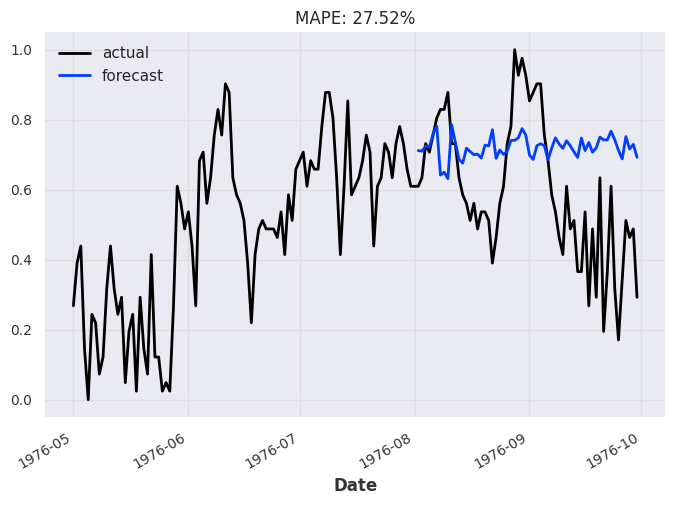

In [ ]:
# this function evaluates a model on a given validation set for n time-steps
def eval_model(model, n, series, val_series):
    pred_series = model.predict(n=n)
    plt.figure(figsize=(8, 5))
    series.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))
    plt.legend()


eval_model(model, 60, series, test)

**Transformer Model**

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

MAPE = 45.74%


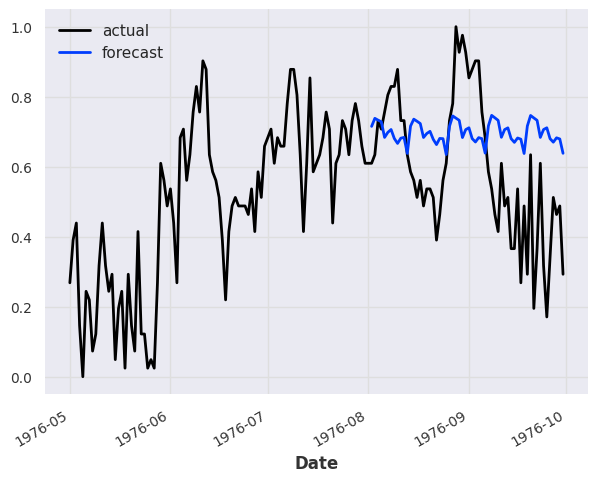

In [ ]:
model = TransformerModel(
    input_chunk_length=24,
    output_chunk_length=12,
    batch_size=2,
    n_epochs= 50,
    model_name="Transformer",
    nr_epochs_val_period=10,
    d_model=16,
    nhead=8,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    activation="relu",
    random_state=42,
    save_checkpoints=True,
    force_reset=True,
)

# fit the model
model.fit(series=train, val_series=test, verbose=True)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

series.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))

**Time-series Dense Encoder**

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params
------------------------------------------------------
0 | criterion        | MSELoss          | 0     
1 | train_metrics    | MetricCollection | 0     
2 | val_metrics      | MetricCollection | 0     
3 | encoders         | Sequential       | 22.9 K
4 | decoders         | Sequential       | 66.0 K
5 | temporal_decoder | _ResidualBlock   | 594   
6 | lookback_skip    | Linear           | 300   
------------------

Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


MAPE = 45.43%


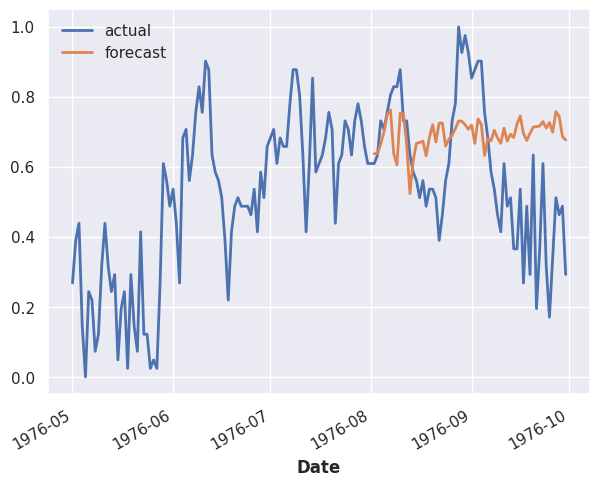

In [ ]:
from darts.models import TiDEModel

model = TiDEModel(
    input_chunk_length=24,
    output_chunk_length=12,
    n_epochs=50,
    random_state=0,
    **generate_torch_kwargs()
)

# fit the model
model.fit(train)

# predict the next 60 instances (n=horizon)
pred = model.predict(n=60)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))

**Prophet Model**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpft5f7icy/nbtzgkja.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpft5f7icy/if_na1t0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82366', 'data', 'file=/tmp/tmpft5f7icy/nbtzgkja.json', 'init=/tmp/tmpft5f7icy/if_na1t0.json', 'output', 'file=/tmp/tmpft5f7icy/prophet_modeljeeeu2k_/prophet_model-20240218205006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.10/dist-packages/

MAPE = nan%


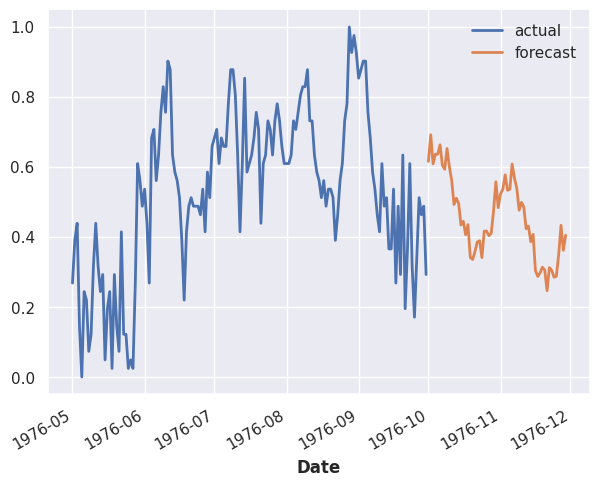

In [ ]:
from darts.models import Prophet
from darts.utils.timeseries_generation import datetime_attribute_timeseries
# optionally, use some future covariates; e.g. the value of the month encoded as a sine and cosine series
future_cov = datetime_attribute_timeseries(series, "day", cyclic=True, add_length=60)
# adding a seasonality (daily, weekly and yearly are included by default) and holidays
model = Prophet(
    add_seasonalities={
        'name':"quarterly_seasonality",
        'seasonal_periods':4,
        'fourier_order':5
        },
)
model.fit(series, future_covariates=future_cov)
pred = model.predict(n=60, future_covariates=future_cov)

# plot the actual data
series.plot(label="actual")
# overlay the actual data with the predictions
pred.plot(label="forecast")

plt.legend()
print("MAPE = {:.2f}%".format(mape(series, pred)))